# predicting implied volatility in option trading using NN(i only used LSTM)

https://www.investopedia.com/terms/i/iv.asp

https://en.wikipedia.org/wiki/Implied_volatility


code here used part of yours, and add some code by me

In [ ]:
# Load libraries
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

# Load the options dataset
options_path = "ndx_option_raw.csv"
options = pd.read_csv(options_path)

# Parse dates and create new features
options['date'] = pd.to_datetime(options['date'])
options['exdate'] = pd.to_datetime(options['exdate'])
options['mid_price'] = (options['best_bid'] + options['best_offer']) / 2
options['days_to_expiry'] = (options['exdate'] - options['date']).dt.days
options['cp_flag_encoded'] = options['cp_flag'].map({'C': 1, 'P': 0})

# Adjust strike price (raw data is multiplied by 1000)
options['strike_price'] = options['strike_price'] / 1000

# Keep only rows without missing critical fields
keep_cols = [
    'strike_price', 'cp_flag_encoded', 'days_to_expiry',
    'impl_volatility', 'delta', 'gamma', 'vega', 'theta', 'mid_price'
]
df = options.dropna(subset=keep_cols)

# Prepare feature matrix X and target vector y
feature_cols = [
    'strike_price', 'cp_flag_encoded',
    'days_to_expiry', 'mid_price', 'delta', 'gamma', 'vega', 'theta'
]
X = df[feature_cols]
y = df['impl_volatility']

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

this code is for toy case MLP, referenced by yours and class note.

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


631/631 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


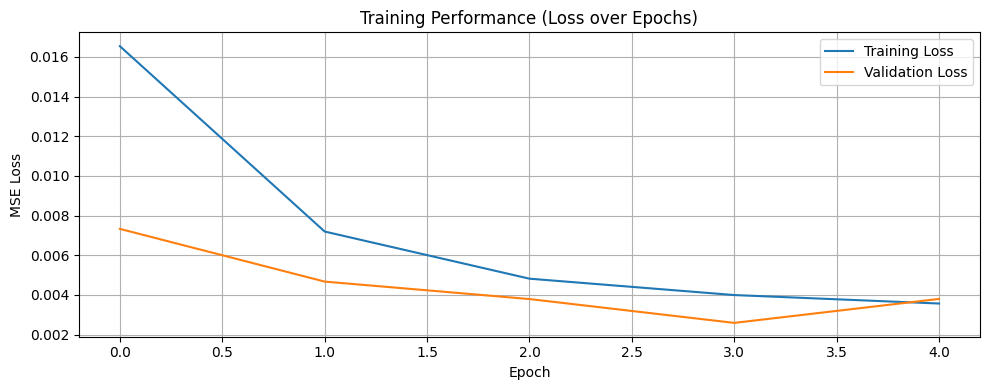

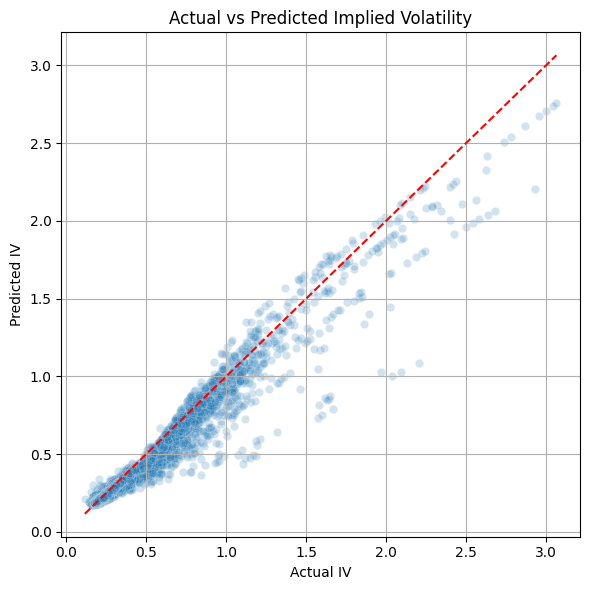

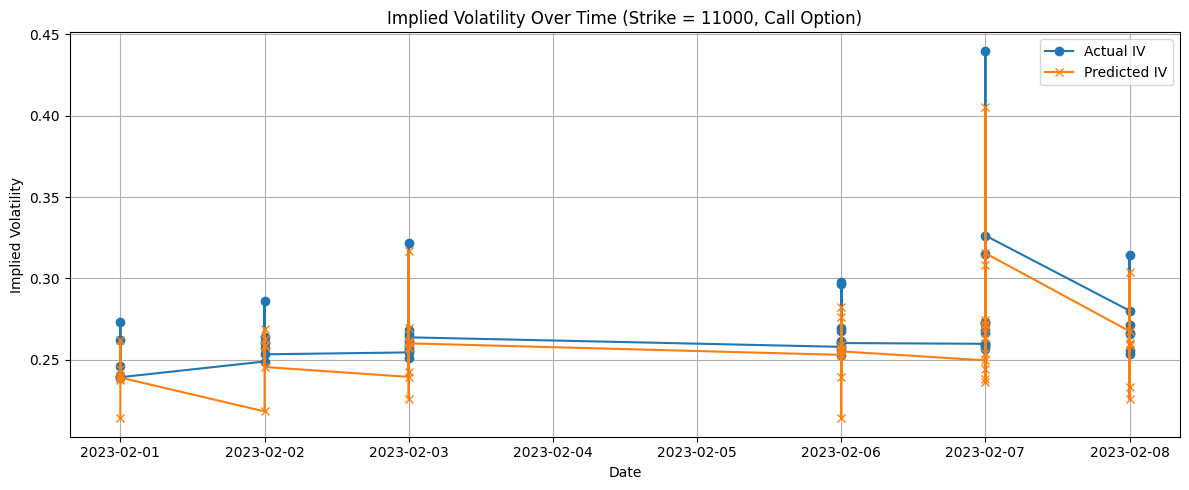

(0.9410497322077886, 0.002600965950289083)

In [ ]:
# Import required libraries
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the input features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Build and compile a feedforward neural network
model = Sequential([
    Dense(256, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.2),
    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dense(1)
])
model.compile(optimizer='adam', loss='mse')

# Set up early stopping to prevent overfitting
early_stop = EarlyStopping(patience=5, restore_best_weights=True)

# Train the model
history = model.fit(
    X_train_scaled, y_train,
    validation_split=0.2,
    epochs=5,
    batch_size=512,
    callbacks=[early_stop],
    verbose=0
)

# Generate predictions
y_pred = model.predict(X_test_scaled).flatten()

# Evaluate performance
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)

# Plot training and validation loss
plt.figure(figsize=(10, 4))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title("Training and Validation Loss over Epochs")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Scatter plot of predicted vs actual values
plt.figure(figsize=(6, 6))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.2)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--')
plt.title("Predicted vs Actual Implied Volatility")
plt.xlabel("Actual IV")
plt.ylabel("Predicted IV")
plt.grid(True)
plt.tight_layout()
plt.show()

# Prepare the test dataset for further analysis
df_test = X_test.copy()
df_test['impl_volatility'] = y_test.values
df_test['predicted_iv'] = y_pred
df_test['date'] = df.loc[y_test.index, 'date']
df_test['cp_flag'] = df.loc[y_test.index, 'cp_flag']
df_test['strike_price'] = df.loc[y_test.index, 'strike_price']

# Select a subset: strike price 12000, call options only
subset = df_test[(df_test['strike_price'] == 12000) & (df_test['cp_flag'] == 'C')].copy()
subset['date'] = pd.to_datetime(subset['date'])
subset = subset.sort_values('date')

# Time series plot: actual vs predicted implied volatility
plt.figure(figsize=(12, 5))
plt.plot(subset['date'], subset['impl_volatility'], label='Actual IV', marker='o')
plt.plot(subset['date'], subset['predicted_iv'], label='Predicted IV', marker='x')
plt.title("Implied Volatility Over Time (Strike = 12000, Call Option)")
plt.xlabel("Date")
plt.ylabel("Implied Volatility")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Output evaluation metrics
r2, mse

In [3]:
df = df.sort_values(by='date') #by date
grouped = df.groupby(['strike_price', 'cp_flag_encoded']) # group by strike price,call or put

In [4]:
from tensorflow.keras.layers import LSTM, Dense
# Create sequences
sequence_length = 3
X_seq, y_seq = [], []
target = 'impl_volatility'
for _, group in grouped:
    group = group.sort_values('date')
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(group[features])
    y_vals = group[target].values

    for i in range(len(group) - sequence_length):
        X_seq.append(X_scaled[i:i+sequence_length])
        y_seq.append(y_vals[i+sequence_length])

X_seq = np.array(X_seq)
y_seq = np.array(y_seq)

X_train, X_test, y_train, y_test = train_test_split(X_seq, y_seq, test_size=0.2, random_state=42)

model = Sequential([
    LSTM(1024, activation='relu', input_shape=(sequence_length, len(features))),
    Dense(512, activation='relu'),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse', metrics=['mse'])
history = model.fit(X_train, y_train, epochs=5, batch_size=512, validation_split=0.1)


y_pred = model.predict(X_test).flatten()


print("R²:", r2_score(y_test, y_pred))
print("MSE:", mean_squared_error(y_test, y_pred))


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/5
137/137 ━━━━━━━━━━━━━━━━━━━━ 8s 33ms/step - loss: 0.0455 - mse: 0.0455 - val_loss: 0.0282 - val_mse: 0.0282
Epoch 2/5
137/137 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.0296 - mse: 0.0296 - val_loss: 0.0259 - val_mse: 0.0259
Epoch 3/5
137/137 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.0284 - mse: 0.0284 - val_loss: 0.0257 - val_mse: 0.0257
Epoch 4/5
137/137 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.0277 - mse: 0.0277 - val_loss: 0.0234 - val_mse: 0.0234
Epoch 5/5
137/137 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.0263 - mse: 0.0263 - val_loss: 0.0234 - val_mse: 0.0234
607/607 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
R²: 0.4177818469410909
MSE: 0.02503285718705119


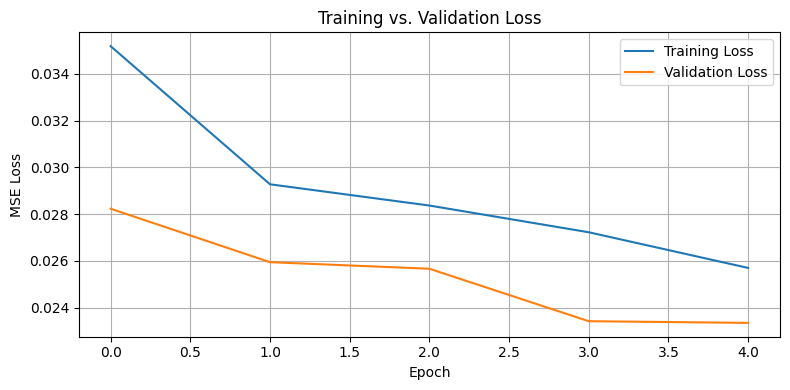

R²: 0.4177818469410909
MSE: 0.02503285718705119


In [5]:
#plots are used the code we normally use for HW,lab for this class
plt.figure(figsize=(8, 4))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title("Training vs. Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
print("R²:", r2_score(y_test, y_pred))
print("MSE:", mean_squared_error(y_test, y_pred))

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


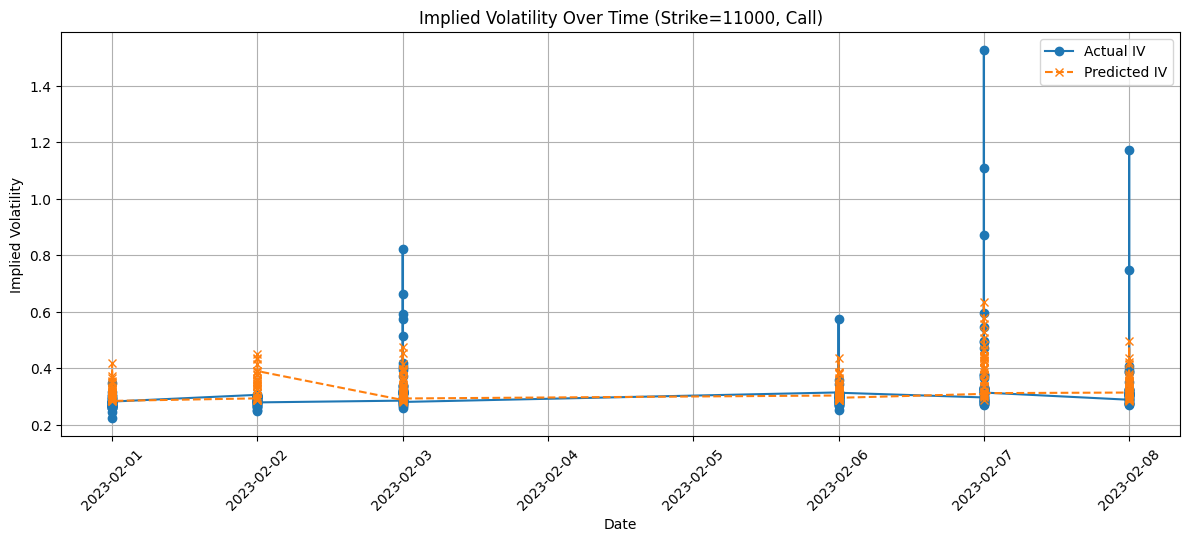

In [ ]:
# Import necessary library
from sklearn.model_selection import train_test_split

# Example: Select call options with strike price 11000
example_strike = 11000
example_cp_flag = 1  # Call option

example_df = df[(df['strike_price'] == example_strike) & (df['cp_flag_encoded'] == example_cp_flag)]
example_df = example_df.sort_values('date')

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(example_df[features])
y_actual = example_df['impl_volatility'].values

# Build sequential input samples
X_seq = []
date_seq = []

for i in range(len(example_df) - sequence_length):
    X_seq.append(X_scaled[i:i+sequence_length])
    date_seq.append(example_df['date'].iloc[i + sequence_length])

X_seq = np.array(X_seq)
y_actual = y_actual[sequence_length:]

# Make predictions
y_pred = model.predict(X_seq).flatten()

# Plot actual vs predicted implied volatility
plt.figure(figsize=(12, 5))
plt.plot(date_seq, y_actual, label='Actual IV', marker='o')
plt.plot(date_seq, y_pred, label='Predicted IV', linestyle='--', marker='x')
plt.title(f"Implied Volatility Prediction (Strike={example_strike}, Call Option)")
plt.xlabel("Date")
plt.ylabel("Implied Volatility")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.xticks(rotation=45)
plt.show()

# Simple RNN with Group K Fold


--- Fold 1 ---


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7716/7716 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step
Fold 1 — MSE: 0.0009, R²: 0.9718

--- Fold 2 ---


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7691/7691 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step
Fold 2 — MSE: 0.0007, R²: 0.9778

--- Fold 3 ---


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7685/7685 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step
Fold 3 — MSE: 0.0021, R²: 0.9395

Cross‑Validation Summary
MSE scores: [0.0009136204017091595, 0.0007319495757145265, 0.0021293686946972563]
R² scores : [0.9717855746230454, 0.9778490737749403, 0.939465138355546]
Average MSE: 0.0013
Average R² : 0.9630


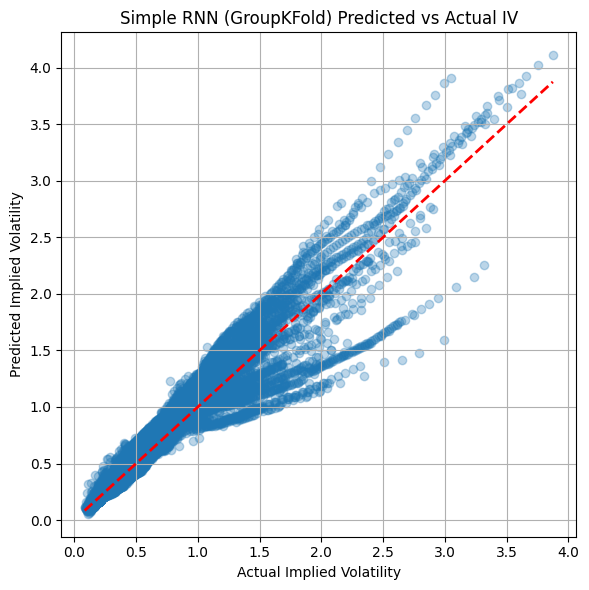

In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense
import matplotlib.pyplot as plt
from sklearn.model_selection import GroupKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score

# Load option data
options_path = "ndx_option_raw.csv"
df = pd.read_csv(options_path)

# Parse dates and engineer features
df['date'] = pd.to_datetime(df['date'])
df['exdate'] = pd.to_datetime(df['exdate'])
df['mid_price'] = (df['best_bid'] + df['best_offer']) / 2
df['days_to_expiry'] = (df['exdate'] - df['date']).dt.days
df['cp_flag_encoded'] = df['cp_flag'].map({'C': 1, 'P': 0})
df['strike_price'] = df['strike_price'] / 1000  # original strike prices were scaled by 1000

# Drop rows missing critical fields
required_cols = [
    'strike_price', 'cp_flag_encoded', 'days_to_expiry',
    'impl_volatility', 'delta', 'gamma', 'vega', 'theta', 'mid_price'
]
df = df.dropna(subset=required_cols)

# Prepare features and target
features = [
    'strike_price', 'cp_flag_encoded', 'days_to_expiry',
    'mid_price', 'delta', 'gamma', 'vega', 'theta'
]
X = df[features].values
y = df['impl_volatility'].values
groups = df['date'].values

# Normalize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Reshape for RNN input (samples, timesteps, features)
X_rnn = X_scaled.reshape((X_scaled.shape[0], 1, X_scaled.shape[1]))

# Set up GroupKFold to avoid same-day leakage
gkf = GroupKFold(n_splits=3)
mse_list = []
r2_list = []

for fold, (train_idx, test_idx) in enumerate(gkf.split(X_rnn, y, groups), start=1):
    print(f"\nFold {fold}")

    X_train, X_test = X_rnn[train_idx], X_rnn[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    # Define a simple RNN model
    model = Sequential([
        SimpleRNN(1024, input_shape=(1, X_rnn.shape[2])),
        Dense(512, activation='relu'),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')

    # Train
    model.fit(X_train, y_train, epochs=30, batch_size=64, verbose=0)

    # Predict and evaluate
    y_pred = model.predict(X_test).flatten()
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    mse_list.append(mse)
    r2_list.append(r2)

    print(f"MSE: {mse:.4f}  |  R²: {r2:.4f}")

# Summarize results
print("\nCross-Validation Results")
print("MSE per fold:", mse_list)
print("R² per fold :", r2_list)
print(f"Average MSE: {np.mean(mse_list):.4f}")
print(f"Average R² : {np.mean(r2_list):.4f}")

# Plot predicted vs actual for the last fold
plt.figure(figsize=(6, 6))
plt.scatter(y_test, y_pred, alpha=0.3)
plt.plot(
    [y_test.min(), y_test.max()],
    [y_test.min(), y_test.max()],
    'r--', linewidth=2
)
plt.xlabel("Actual Implied Volatility")
plt.ylabel("Predicted Implied Volatility")
plt.title("Simple RNN — Predicted vs Actual")
plt.grid(True)
plt.tight_layout()
plt.show()


--- Fold 1 ---


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7716/7716 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step
Fold 1 — MSE: 0.0005, R²: 0.9838

--- Fold 2 ---


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7691/7691 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step
Fold 2 — MSE: 0.0006, R²: 0.9825

--- Fold 3 ---


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7685/7685 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step
Fold 3 — MSE: 0.0027, R²: 0.9245

Cross‑Validation Summary
MSE scores: [0.0005 0.0006 0.0027]
R² scores : [0.9838 0.9825 0.9245]
Average MSE: 0.0013
Average R² : 0.9636


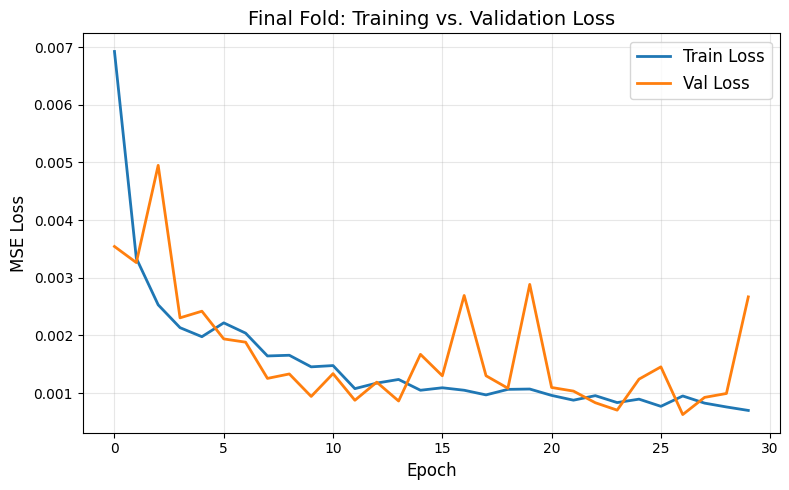

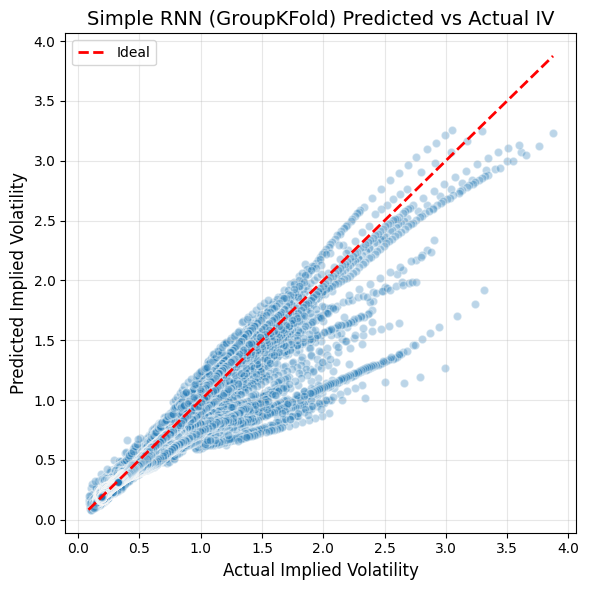

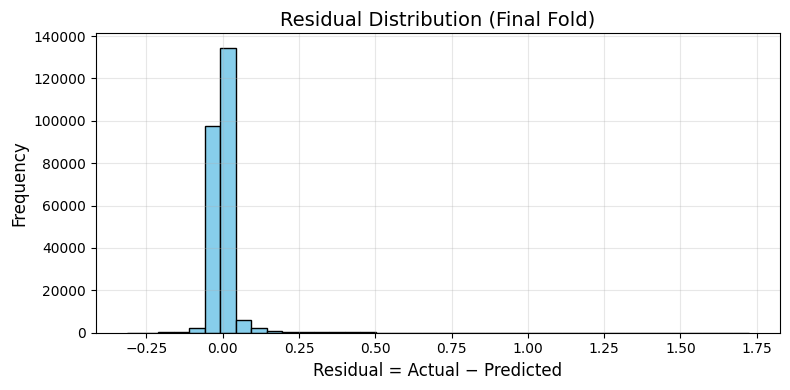

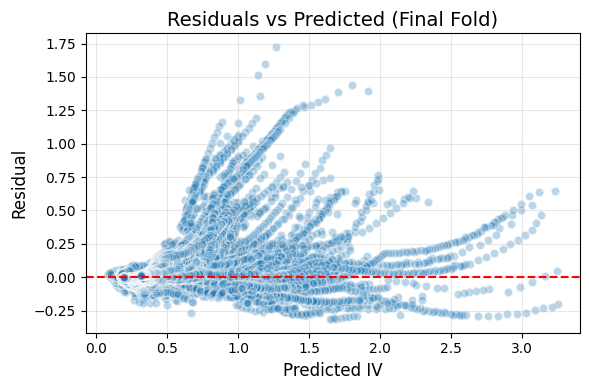

In [ ]:
# Import libraries
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import GroupKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense

# Load option data
df = pd.read_csv("ndx_option_raw.csv")

# Preprocess dates and basic feature engineering
df['date'] = pd.to_datetime(df['date'])
df['exdate'] = pd.to_datetime(df['exdate'])
df['mid_price'] = (df['best_bid'] + df['best_offer']) / 2
df['days_to_expiry'] = (df['exdate'] - df['date']).dt.days
df['cp_flag_encoded'] = df['cp_flag'].map({'C': 1, 'P': 0})
df['strike_price'] = df['strike_price'] / 1000  # adjust strike scale

# Drop rows missing important fields
required_cols = [
    'strike_price', 'cp_flag_encoded', 'days_to_expiry',
    'impl_volatility', 'delta', 'gamma', 'vega', 'theta', 'mid_price'
]
df = df.dropna(subset=required_cols)

# Set up features and target
features = [
    'strike_price', 'cp_flag_encoded', 'days_to_expiry',
    'mid_price', 'delta', 'gamma', 'vega', 'theta'
]
X = df[features].values
y = df['impl_volatility'].values
groups = df['date'].values  # group labels for GroupKFold

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Reshape input for RNN (samples, timesteps, features)
X_rnn = X_scaled.reshape((X_scaled.shape[0], 1, X_scaled.shape[1]))

# Set up GroupKFold CV
gkf = GroupKFold(n_splits=3)
mse_scores, r2_scores = [], []
train_histories = []

for fold_idx, (train_idx, test_idx) in enumerate(gkf.split(X_rnn, y, groups), start=1):
    print(f"\nFold {fold_idx}")

    X_train, X_test = X_rnn[train_idx], X_rnn[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    # Define RNN model
    model = Sequential([
        SimpleRNN(1024, input_shape=(1, X_rnn.shape[2])),
        Dense(512, activation='relu'),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')

    # Train with validation split
    history = model.fit(
        X_train, y_train,
        validation_split=0.1,
        epochs=30,
        batch_size=64,
        verbose=0
    )
    train_histories.append(history)

    # Prediction and evaluation
    y_pred = model.predict(X_test).flatten()
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    mse_scores.append(mse)
    r2_scores.append(r2)

    print(f"MSE = {mse:.4f}, R² = {r2:.4f}")

# Summarize CV results
print("\nCross-Validation Summary")
print("MSE per fold:", np.round(mse_scores, 4))
print("R² per fold :", np.round(r2_scores, 4))
print(f"Avg MSE: {np.mean(mse_scores):.4f}")
print(f"Avg R² : {np.mean(r2_scores):.4f}")

# Plot training/validation loss for the last fold
last_history = train_histories[-1]

plt.figure(figsize=(8, 5))
plt.plot(last_history.history['loss'], label='Train Loss')
plt.plot(last_history.history['val_loss'], label='Validation Loss')
plt.title("Training vs Validation Loss (Final Fold)", fontsize=14)
plt.xlabel("Epoch", fontsize=12)
plt.ylabel("MSE Loss", fontsize=12)
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# Plot predicted vs actual for the final fold
plt.figure(figsize=(6, 6))
plt.scatter(y_test, y_pred, alpha=0.3, edgecolor='w')
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()],
         'r--', linewidth=2)
plt.title("Predicted vs Actual IV (Final Fold)", fontsize=14)
plt.xlabel("Actual Implied Volatility", fontsize=12)
plt.ylabel("Predicted Implied Volatility", fontsize=12)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# Analyze residuals
residuals = y_test - y_pred

plt.figure(figsize=(8, 4))
plt.hist(residuals, bins=40, color='skyblue', edgecolor='k')
plt.title("Residuals Distribution (Final Fold)", fontsize=14)
plt.xlabel("Residual", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

plt.figure(figsize=(6, 4))
plt.scatter(y_pred, residuals, alpha=0.3, edgecolor='w')
plt.axhline(0, color='r', linestyle='--', linewidth=1.5)
plt.title("Residuals vs Predicted (Final Fold)", fontsize=14)
plt.xlabel("Predicted IV", fontsize=12)
plt.ylabel("Residual", fontsize=12)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# RNN (Group K Fold = 3)


--- RNN Fold 1 ---
Epoch 1/40
3460/3460 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - loss: 0.0337 - val_loss: 0.0079 - learning_rate: 0.0010
Epoch 2/40
3460/3460 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - loss: 0.0090 - val_loss: 0.0054 - learning_rate: 0.0010
Epoch 3/40
3460/3460 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - loss: 0.0084 - val_loss: 0.0052 - learning_rate: 0.0010
Epoch 4/40
3460/3460 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - loss: 0.0070 - val_loss: 0.0036 - learning_rate: 0.0010
Epoch 5/40
3460/3460 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - loss: 0.0067 - val_loss: 0.0049 - learning_rate: 0.0010
Epoch 6/40
3460/3460 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - loss: 0.0066 - val_loss: 0.0035 - learning_rate: 0.0010
Epoch 7/40
3460/3460 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.0067 - val_loss: 0.0052 - learning_rate: 0.0010
Epoch 8/40
3460/3460 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - loss: 0.0068 - val_loss: 0.0032 - learning_rate: 0.0010
Epoch 9/40
3460/3460 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.0065 - val_loss: 0.0

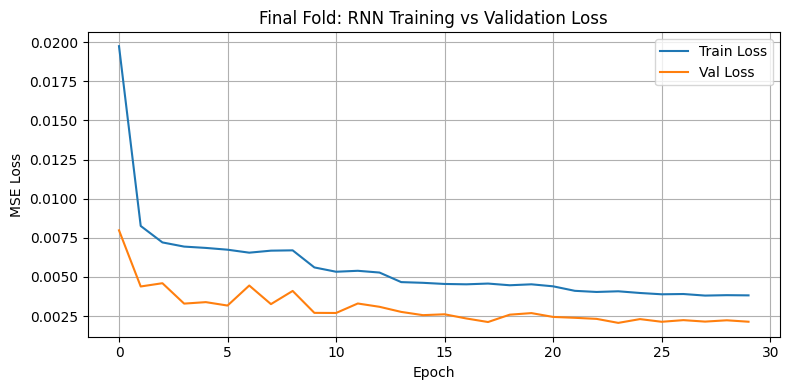

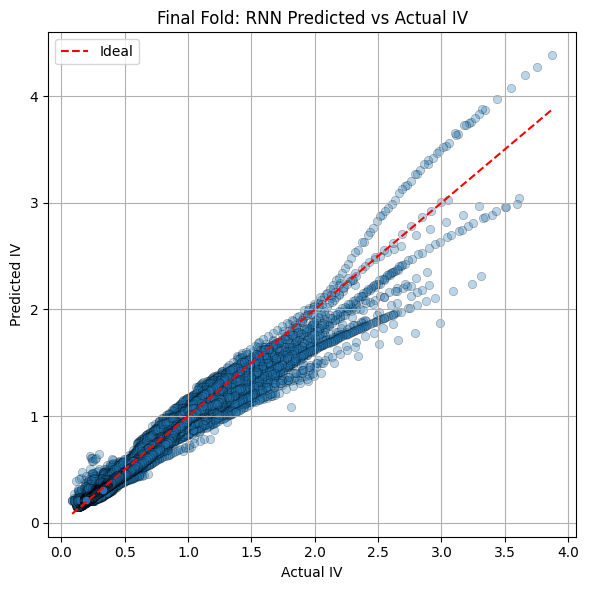

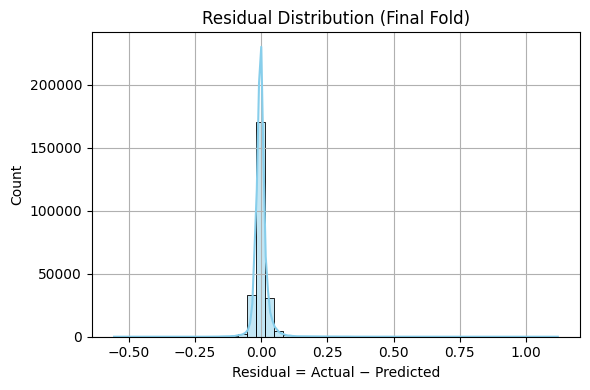

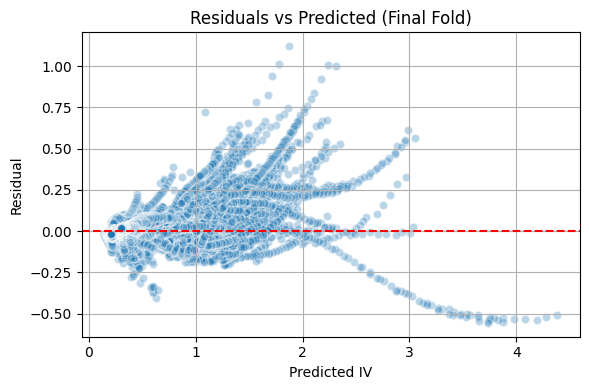

In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import GroupKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Dropout, Input
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2

# =========================
# Data Loading and Preprocessing
# =========================
df = pd.read_csv("./dataset/ndx_option_raw.csv", parse_dates=["date", "exdate"])

# Basic feature engineering
df["mid_price"] = (df["best_bid"] + df["best_offer"]) / 2
df["days_to_expiry"] = (df["exdate"] - df["date"]).dt.days
df["cp_flag_encoded"] = df["cp_flag"].map({"C": 1, "P": 0})
df["strike_price"] = df["strike_price"] / 1000  # adjust strike scaling

# Filter out rows with missing values in critical fields
required_cols = [
    "strike_price", "cp_flag_encoded", "days_to_expiry",
    "impl_volatility", "delta", "gamma", "vega", "theta", "mid_price"
]
df = df.dropna(subset=required_cols)

# Set up feature matrix and target
feature_cols = [
    "strike_price", "cp_flag_encoded", "days_to_expiry",
    "mid_price", "delta", "gamma", "vega", "theta"
]
X = df[feature_cols].values
y = df["impl_volatility"].values
groups = df["date"].values

# Standardize feature columns
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Reshape for RNN input (samples, timesteps=1, features)
X_rnn = X_scaled.reshape((-1, 1, X_scaled.shape[1]))

# =========================
# Model Training with GroupKFold
# =========================
gkf = GroupKFold(n_splits=3)
mse_scores, r2_scores = [], []
histories = []
final_true, final_pred = None, None

for fold_idx, (train_idx, test_idx) in enumerate(gkf.split(X_rnn, y, groups), start=1):
    print(f"\nFold {fold_idx}:")

    X_train, X_test = X_rnn[train_idx], X_rnn[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    # Define the model
    model = Sequential([
        Input(shape=(1, X_train.shape[2])),
        SimpleRNN(128, activation="tanh",
                  kernel_regularizer=l2(1e-4),
                  recurrent_regularizer=l2(1e-4)),
        Dropout(0.3),
        Dense(64, activation="relu", kernel_regularizer=l2(1e-4)),
        Dropout(0.3),
        Dense(32, activation="relu", kernel_regularizer=l2(1e-4)),
        Dropout(0.2),
        Dense(1)
    ])
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3), loss="mse")

    # Callbacks
    callbacks = [
        EarlyStopping(monitor="val_loss", patience=6, restore_best_weights=True, verbose=1),
        ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3, min_lr=1e-5, verbose=1)
    ]

    # Fit the model
    history = model.fit(
        X_train, y_train,
        validation_split=0.1,
        epochs=40,
        batch_size=128,
        callbacks=callbacks,
        verbose=1
    )
    histories.append(history)

    # Predictions
    y_pred = model.predict(X_test, verbose=0).flatten()

    # Evaluation
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    mse_scores.append(mse)
    r2_scores.append(r2)

    print(f"MSE: {mse:.5f}, R²: {r2:.4f}")

    # Save final fold predictions for visualization
    if fold_idx == 3:
        final_true, final_pred = y_test, y_pred

# =========================
# Cross-Validation Results
# =========================
print("\nCross-Validation Summary:")
print("MSE scores per fold:", np.round(mse_scores, 5))
print("R² scores per fold :", np.round(r2_scores, 4))
print(f"Average MSE: {np.mean(mse_scores):.5f}")
print(f"Average R² : {np.mean(r2_scores):.4f}")

# =========================
# Visualization
# =========================
# Loss curves for final fold
last_hist = histories[-1]
plt.figure(figsize=(8, 4))
plt.plot(last_hist.history["loss"], label="Train Loss")
plt.plot(last_hist.history["val_loss"], label="Validation Loss")
plt.title("Training vs Validation Loss (Final Fold)")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Predicted vs Actual scatter plot
plt.figure(figsize=(6, 6))
plt.scatter(final_true, final_pred, alpha=0.3, edgecolor="k", linewidth=0.5)
plt.plot([final_true.min(), final_true.max()], [final_true.min(), final_true.max()],
         "r--", label="Ideal")
plt.title("Predicted vs Actual Implied Volatility (Final Fold)")
plt.xlabel("Actual IV")
plt.ylabel("Predicted IV")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Residual distribution
residuals = final_true - final_pred
plt.figure(figsize=(6, 4))
sns.histplot(residuals, bins=50, kde=True, color="skyblue")
plt.title("Residual Distribution (Final Fold)")
plt.xlabel("Residual")
plt.ylabel("Count")
plt.grid(True)
plt.tight_layout()
plt.show()

# Residuals vs Predictions
plt.figure(figsize=(6, 4))
plt.scatter(final_pred, residuals, alpha=0.3, edgecolor="w")
plt.axhline(0, color="red", linestyle="--", linewidth=1.5)
plt.title("Residuals vs Predicted Values (Final Fold)")
plt.xlabel("Predicted IV")
plt.ylabel("Residual")
plt.grid(True)
plt.tight_layout()
plt.show()

# LSTM (Group K Fold)

In [ ]:
# Import libraries
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from sklearn.model_selection import GroupKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2

# =====================
# Load and prepare the data
# =====================
df = pd.read_csv("./dataset/ndx_option_raw.csv", parse_dates=["date", "exdate"])

# Basic feature engineering
df["mid_price"] = (df["best_bid"] + df["best_offer"]) / 2
df["days_to_expiry"] = (df["exdate"] - df["date"]).dt.days
df["cp_flag_encoded"] = df["cp_flag"].map({"C": 1, "P": 0})
df["strike_price"] = df["strike_price"] / 1000  # adjust scale

# Filter for complete records
required_cols = [
    "strike_price", "cp_flag_encoded", "days_to_expiry",
    "impl_volatility", "delta", "gamma", "vega", "theta", "mid_price"
]
df = df.dropna(subset=required_cols)

features = [
    "strike_price", "cp_flag_encoded", "days_to_expiry",
    "mid_price", "delta", "gamma", "vega", "theta"
]
X = df[features].values
y = df["impl_volatility"].values
groups = df["date"].values

# Standardize input features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Prepare LSTM input shape: (samples, timesteps=1, features)
X_lstm = X_scaled.reshape((-1, 1, X_scaled.shape[1]))

# =====================
# Model setup and cross-validation
# =====================
gkf = GroupKFold(n_splits=3)
mse_list, r2_list = [], []

for fold_idx, (train_idx, test_idx) in enumerate(gkf.split(X_lstm, y, groups), start=1):
    print(f"\nFold {fold_idx}")

    X_train, X_test = X_lstm[train_idx], X_lstm[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    # Build LSTM network
    model = Sequential([
        Input(shape=(1, X_train.shape[2])),
        LSTM(
            128, activation="tanh",
            kernel_regularizer=l2(1e-4),
            recurrent_regularizer=l2(1e-4),
            return_sequences=False
        ),
        Dropout(0.3),
        Dense(64, activation="relu", kernel_regularizer=l2(1e-4)),
        Dropout(0.3),
        Dense(32, activation="relu", kernel_regularizer=l2(1e-4)),
        Dropout(0.2),
        Dense(1)
    ])

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
        loss="mse"
    )

    callbacks = [
        EarlyStopping(monitor="val_loss", patience=7, restore_best_weights=True, verbose=1),
        ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3, min_lr=1e-5, verbose=1)
    ]

    history = model.fit(
        X_train, y_train,
        validation_split=0.1,
        epochs=50,
        batch_size=128,
        callbacks=callbacks,
        verbose=1
    )

    # Prediction and evaluation
    y_pred = model.predict(X_test, verbose=0).flatten()
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    mse_list.append(mse)
    r2_list.append(r2)

    print(f"Test MSE: {mse:.5f}, Test R²: {r2:.4f}")

    if fold_idx == 3:
        y_test_lstm, y_pred_lstm = y_test, y_pred

# =====================
# Summary results
# =====================
print("\nCross-Validation Summary:")
print("MSE per fold:", np.round(mse_list, 5))
print("R²  per fold:", np.round(r2_list, 4))
print(f"Average MSE: {np.mean(mse_list):.5f}")
print(f"Average R² : {np.mean(r2_list):.4f}")


--- LSTM Fold 1 ---
Epoch 1/50
3460/3460 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 0.0236 - val_loss: 0.0055 - learning_rate: 0.0010
Epoch 2/50
3460/3460 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 0.0084 - val_loss: 0.0057 - learning_rate: 0.0010
Epoch 3/50
3460/3460 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - loss: 0.0078 - val_loss: 0.0048 - learning_rate: 0.0010
Epoch 4/50
3460/3460 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - loss: 0.0073 - val_loss: 0.0045 - learning_rate: 0.0010
Epoch 5/50
3460/3460 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - loss: 0.0070 - val_loss: 0.0039 - learning_rate: 0.0010
Epoch 6/50
3460/3460 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - loss: 0.0066 - val_loss: 0.0040 - learning_rate: 0.0010
Epoch 7/50
3460/3460 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - loss: 0.0068 - val_loss: 0.0049 - learning_rate: 0.0010
Epoch 8/50
3458/3460 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0065
Epoch 8: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
3460/3460 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - los

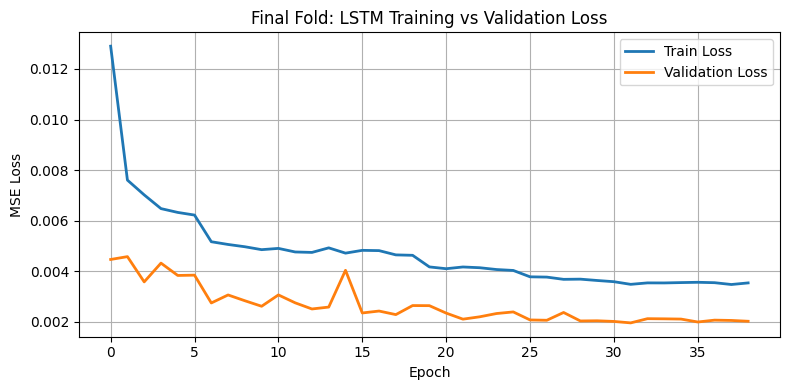

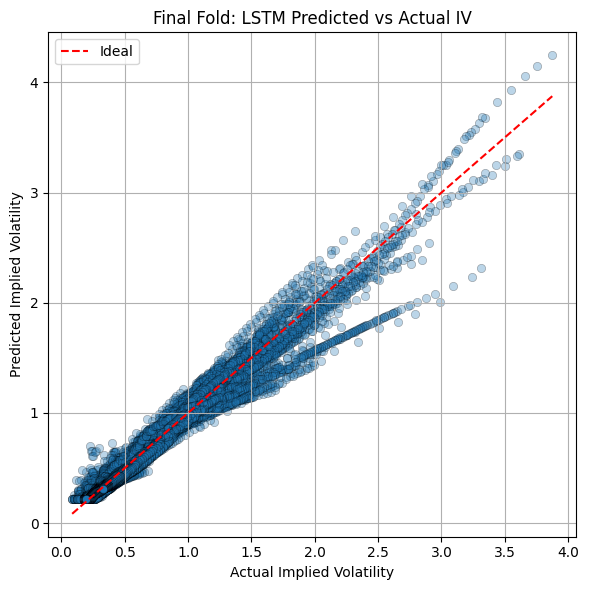

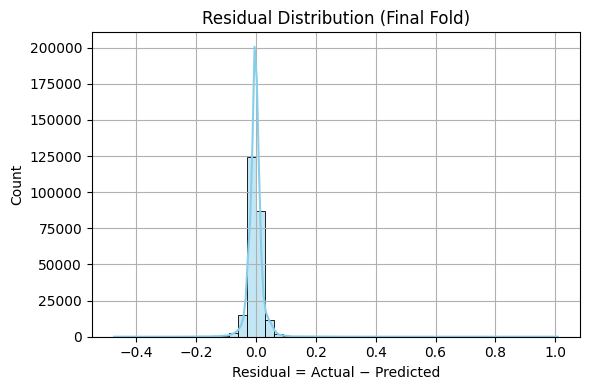

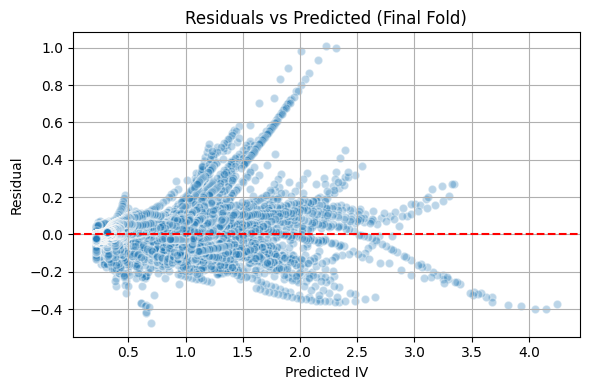

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Visualizations for Final Fold

# Train vs Validation Loss (final fold)
plt.figure(figsize=(8, 4))
plt.plot(history.history["loss"], label="Train Loss", linewidth=2)
plt.plot(history.history["val_loss"], label="Validation Loss", linewidth=2)
plt.title("Final Fold: LSTM Training vs Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Predicted vs Actual Plot (final fold)
plt.figure(figsize=(6, 6))
plt.scatter(y_test, y_pred, alpha=0.3, edgecolor='k', linewidth=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', label="Ideal")
plt.title("Final Fold: LSTM Predicted vs Actual IV")
plt.xlabel("Actual Implied Volatility")
plt.ylabel("Predicted Implied Volatility")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Residual Distribution (final fold)
residuals = y_test - y_pred
plt.figure(figsize=(6, 4))
sns.histplot(residuals, bins=50, kde=True, color="skyblue")
plt.title("Residual Distribution (Final Fold)")
plt.xlabel("Residual = Actual − Predicted")
plt.ylabel("Count")
plt.grid(True)
plt.tight_layout()
plt.show()

# Residuals vs Predicted (final fold)
plt.figure(figsize=(6, 4))
plt.scatter(y_pred, residuals, alpha=0.3, edgecolor='w')
plt.axhline(0, color="red", linestyle="--", linewidth=1.5)
plt.title("Residuals vs Predicted (Final Fold)")
plt.xlabel("Predicted IV")
plt.ylabel("Residual")
plt.grid(True)
plt.tight_layout()
plt.show()

# GRU (Group K Fold)

In [17]:
# # GRU-based Implied Volatility Prediction (Colab GPU-Compatible)

# import pandas as pd
# import numpy as np
# import matplotlib.pyplot as plt
# import seaborn as sns

# from sklearn.model_selection import GroupKFold
# from sklearn.preprocessing import StandardScaler
# from sklearn.linear_model import LinearRegression
# from sklearn.ensemble import RandomForestRegressor
# from sklearn.metrics import mean_squared_error, r2_score

# import tensorflow as tf
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import GRU, Dense, Dropout
# from tensorflow.keras.callbacks import EarlyStopping

# # ---------------------------
# # GPU Setup & Verification
# # ---------------------------
# # List and confirm available GPUs
# gpus = tf.config.list_physical_devices('GPU')
# print("Available GPUs:", gpus)

# # Enable device placement logging so we can see ops on GPU
# tf.debugging.set_log_device_placement(True)

# # Optionally set memory growth to avoid allocating all GPU memory at once
# if gpus:
#     try:
#         for gpu in gpus:
#             tf.config.experimental.set_memory_growth(gpu, True)
#     except RuntimeError as e:
#         print(e)

# # ---------------------------
# # Step 1: Load & preprocess
# # ---------------------------
# # Load raw options data
# df = pd.read_csv("ndx_option_raw.csv")

# # Parse dates and compute derived features
# df['date']           = pd.to_datetime(df['date'])
# df['exdate']         = pd.to_datetime(df['exdate'])
# df['mid_price']      = (df['best_bid'] + df['best_offer']) / 2
# df['days_to_expiry'] = (df['exdate'] - df['date']).dt.days
# df['cp_flag_encoded']= df['cp_flag'].map({'C':1,'P':0})
# df['strike_price']   = df['strike_price'] / 1000.0

# # Drop rows missing any critical column
# required = [
#     'strike_price','cp_flag_encoded','days_to_expiry',
#     'impl_volatility','delta','gamma','vega','theta','mid_price'
# ]
# df = df.dropna(subset=required)

# # Build feature matrix X and target y
# features = [
#     'strike_price','cp_flag_encoded','days_to_expiry',
#     'mid_price','delta','gamma','vega','theta'
# ]
# X = df[features].values
# y = df['impl_volatility'].values
# groups = df['date'].values  # for time-aware splitting

# # Standardize all features
# scaler = StandardScaler()
# X_scaled = scaler.fit_transform(X)

# # Reshape for GRU: (samples, timesteps=1, features)
# X_gru = X_scaled.reshape((X_scaled.shape[0], 1, X_scaled.shape[1]))

# # ---------------------------
# # Step 2: GRU + GroupKFold CV
# # ---------------------------
# gkf = GroupKFold(n_splits=3)
# gru_mse, gru_r2 = [], []
# histories = []
# final_pred, final_true = None, None

# for fold, (train_idx, test_idx) in enumerate(gkf.split(X_gru, y, groups), start=1):
#     print(f"\n--- GRU Fold {fold} ---")
#     X_tr, X_te = X_gru[train_idx], X_gru[test_idx]
#     y_tr, y_te = y[train_idx], y[test_idx]

#     # Build GRU regression model
#     with tf.device('/GPU:0'):
#         model = Sequential([
#             GRU(1024, input_shape=(1, X_gru.shape[2]), return_sequences=False),
#             Dropout(0.3),
#             Dense(512, activation='relu'),
#             Dropout(0.3),
#             Dense(1)
#         ])
#         model.compile(optimizer='adam', loss='mse')

#         # Early stopping based on validation loss
#         early_stop = EarlyStopping(
#             monitor='val_loss', patience=5, restore_best_weights=True
#         )

#         # Train on GPU
#         history = model.fit(
#             X_tr, y_tr,
#             epochs=30,
#             batch_size=256,
#             validation_split=0.1,
#             callbacks=[early_stop],
#             verbose=1
#         )

#     # Evaluate on test fold
#     y_pred = model.predict(X_te).flatten()
#     mse = mean_squared_error(y_te, y_pred)
#     r2  = r2_score(y_te, y_pred)
#     gru_mse.append(mse)
#     gru_r2.append(r2)

#     print(f"Fold {fold} — MSE: {mse:.4f}, R²: {r2:.4f}")

#     # Save history and final predictions for last fold
#     if fold == 3:
#         histories.append(history)
#         final_pred, final_true = y_pred, y_te



# # ---------------------------
# # Step 4: Visualizations
# # ---------------------------
# # 4.1 Training & Validation Loss for last fold
# hist = histories[0]
# plt.figure(figsize=(8,4))
# plt.plot(hist.history['loss'], label='Train Loss')
# plt.plot(hist.history['val_loss'], label='Val Loss')
# plt.title("GRU Fold 5: Training vs Validation Loss")
# plt.xlabel("Epoch")
# plt.ylabel("MSE Loss")
# plt.legend()
# plt.grid(True)
# plt.tight_layout()
# plt.show()

# # 4.2 Final Fold: Predicted vs Actual
# plt.figure(figsize=(6,6))
# plt.scatter(final_true, final_pred, alpha=0.3, edgecolor='k', linewidth=0.1)
# plt.plot([final_true.min(), final_true.max()],
#          [final_true.min(), final_true.max()],
#          'r--', label='Ideal')
# plt.title("GRU Fold 5: Predicted vs Actual IV")
# plt.xlabel("Actual Implied Volatility")
# plt.ylabel("Predicted Implied Volatility")
# plt.legend()
# plt.grid(True)
# plt.tight_layout()
# plt.show()

# # 4.3 Residuals Distribution
# residuals = final_true - final_pred
# plt.figure(figsize=(6,4))
# sns.histplot(residuals, bins=50, kde=True)
# plt.title("Residual Distribution (GRU Fold 5)")
# plt.xlabel("Residual = Actual − Predicted")
# plt.tight_layout()
# plt.show()

# # 4.4 Comparison Bar Chart: MSE & R²
# labels = ['LinearReg', 'RandomForest', 'GRU']
# avg_mse = [np.mean(gru_mse)]
# avg_r2  = [np.mean(gru_r2)]

# x = np.arange(len(labels))
# width = 0.35

# fig, ax1 = plt.subplots(figsize=(7,4))
# ax2 = ax1.twinx()
# ax1.bar(x - width/2, avg_mse, width, label='Avg MSE', color='skyblue')
# ax2.bar(x + width/2, avg_r2, width, label='Avg R²', color='salmon')

# ax1.set_xticks(x)
# ax1.set_xticklabels(labels)
# ax1.set_ylabel('Avg MSE')
# ax2.set_ylabel('Avg R²')
# ax1.set_title("Model Performance Comparison (5-Fold)")
# ax1.legend(loc='upper left')
# ax2.legend(loc='upper right')
# plt.tight_layout()
# plt.show()

# # ---------------------------
# # Step 5: Final Summary
# # ---------------------------
# print("\nGRU Cross-Validation Summary:")
# print("MSE scores:", np.round(gru_mse, 4))
# print("R² scores:", np.round(gru_r2, 4))
# print(f"Average MSE: {np.mean(gru_mse):.4f}")
# print(f"Average R² : {np.mean(gru_r2):.4f}")

# GRU K=3


--- GRU Fold 1 ---
Epoch 1/40
3460/3460 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - loss: 0.0220 - val_loss: 0.0063 - learning_rate: 0.0010
Epoch 2/40
3460/3460 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - loss: 0.0076 - val_loss: 0.0043 - learning_rate: 0.0010
Epoch 3/40
3460/3460 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - loss: 0.0070 - val_loss: 0.0037 - learning_rate: 0.0010
Epoch 4/40
3460/3460 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - loss: 0.0065 - val_loss: 0.0039 - learning_rate: 0.0010
Epoch 5/40
3460/3460 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 0.0063 - val_loss: 0.0050 - learning_rate: 0.0010
Epoch 6/40
3460/3460 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - loss: 0.0064 - val_loss: 0.0036 - learning_rate: 0.0010
Epoch 7/40
3460/3460 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - loss: 0.0065 - val_loss: 0.0035 - learning_rate: 0.0010
Epoch 8/40
3460/3460 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - loss: 0.0059 - val_loss: 0.0035 - learning_rate: 0.0010
Epoch 9/40
3460/3460 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - loss: 0.0060 - val_loss: 0.

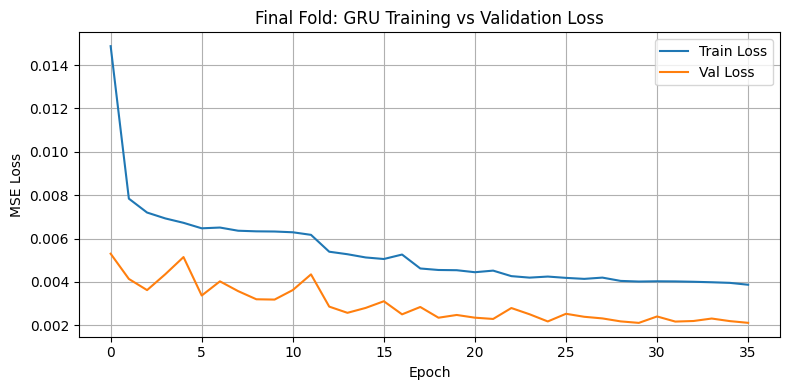

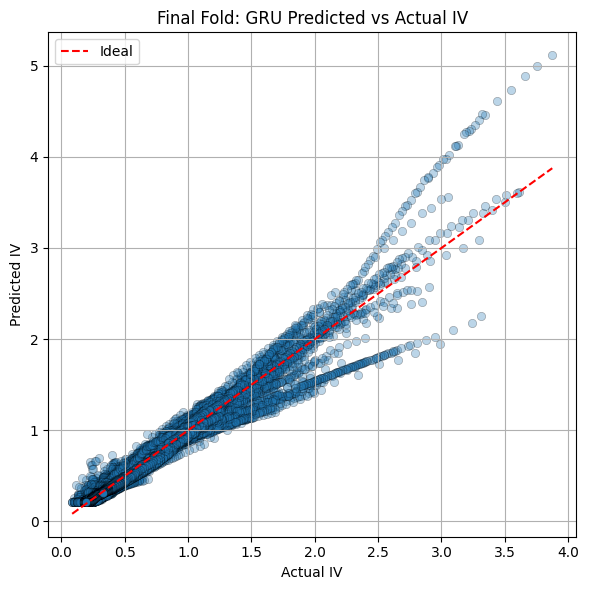

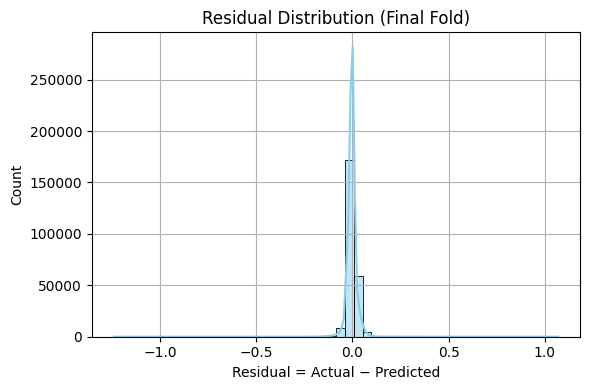

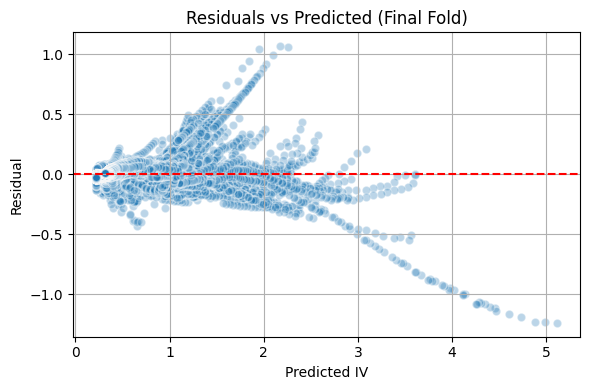

In [ ]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import GroupKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout, Input
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# ===================================
# Data Loading and Preprocessing
# ===================================
df = pd.read_csv("./dataset/ndx_option_raw.csv", parse_dates=["date", "exdate"])

# Basic feature engineering
df["mid_price"] = (df["best_bid"] + df["best_offer"]) / 2
df["days_to_expiry"] = (df["exdate"] - df["date"]).dt.days
df["cp_flag_encoded"] = df["cp_flag"].map({"C": 1, "P": 0})
df["strike_price"] = df["strike_price"] / 1000.0

# Filter incomplete rows
required_cols = [
    "strike_price", "cp_flag_encoded", "days_to_expiry",
    "impl_volatility", "delta", "gamma", "vega", "theta", "mid_price"
]
df = df.dropna(subset=required_cols)

# Prepare features and targets
features = [
    "strike_price", "cp_flag_encoded", "days_to_expiry",
    "mid_price", "delta", "gamma", "vega", "theta"
]
X = df[features].values
y = df["impl_volatility"].values
groups = df["date"].values

# Standardization
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_gru = X_scaled.reshape((-1, 1, X_scaled.shape[1]))  # reshape for GRU input

# ===================================
# GRU Model with GroupKFold Cross-validation
# ===================================
gkf = GroupKFold(n_splits=3)
gru_mse, gru_r2 = [], []
histories = []

for fold, (train_idx, test_idx) in enumerate(gkf.split(X_gru, y, groups), start=1):
    print(f"\nFold {fold}")

    X_train, X_test = X_gru[train_idx], X_gru[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    model = Sequential([
        Input(shape=(1, X_train.shape[2])),
        GRU(128, activation="tanh",
            kernel_regularizer=l2(1e-4),
            recurrent_regularizer=l2(1e-4)),
        Dropout(0.3),
        Dense(64, activation="relu", kernel_regularizer=l2(1e-4)),
        Dropout(0.3),
        Dense(32, activation="relu", kernel_regularizer=l2(1e-4)),
        Dropout(0.2),
        Dense(1)
    ])

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
        loss="mse"
    )

    callbacks = [
        EarlyStopping(monitor="val_loss", patience=6, restore_best_weights=True, verbose=1),
        ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3, min_lr=1e-5, verbose=1)
    ]

    history = model.fit(
        X_train, y_train,
        epochs=40,
        batch_size=128,
        validation_split=0.1,
        callbacks=callbacks,
        verbose=1
    )

    y_pred = model.predict(X_test, verbose=0).flatten()
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    gru_mse.append(mse)
    gru_r2.append(r2)

    print(f"Test MSE: {mse:.5f}, Test R²: {r2:.4f}")

    if fold == 3:
        final_pred, final_true = y_pred, y_test
        histories.append(history)

# ===================================
# Evaluation Summary
# ===================================
print("\nCross-validation results:")
print("MSE per fold:", np.round(gru_mse, 5))
print("R² per fold :", np.round(gru_r2, 4))
print(f"Avg MSE: {np.mean(gru_mse):.5f}")
print(f"Avg R² : {np.mean(gru_r2):.4f}")

# ===================================
# Visualization (Final Fold)
# ===================================
# Loss curves
hist = histories[0]
plt.figure(figsize=(8,4))
plt.plot(hist.history["loss"], label="Train Loss")
plt.plot(hist.history["val_loss"], label="Validation Loss")
plt.title("Training and Validation Loss (Final Fold)")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Predicted vs Actual
plt.figure(figsize=(6,6))
plt.scatter(final_true, final_pred, alpha=0.3, edgecolor="k", linewidth=0.5)
plt.plot([final_true.min(), final_true.max()],
         [final_true.min(), final_true.max()],
         "r--", label="Ideal")
plt.title("Predicted vs Actual (Final Fold)")
plt.xlabel("Actual Implied Volatility")
plt.ylabel("Predicted Implied Volatility")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Residual distribution
residuals = final_true - final_pred
plt.figure(figsize=(6,4))
sns.histplot(residuals, bins=50, kde=True, color="skyblue")
plt.title("Residual Distribution (Final Fold)")
plt.xlabel("Residual = Actual - Predicted")
plt.ylabel("Count")
plt.grid(True)
plt.tight_layout()
plt.show()

# Residuals vs Predicted
plt.figure(figsize=(6,4))
plt.scatter(final_pred, residuals, alpha=0.3, edgecolor="w")
plt.axhline(0, color="red", linestyle="--", linewidth=1.5)
plt.title("Residuals vs Predicted (Final Fold)")
plt.xlabel("Predicted IV")
plt.ylabel("Residual")
plt.grid(True)
plt.tight_layout()
plt.show()

# Visualization

In [ ]:
# these lists must exist from your training loops
mse_rnn, r2_rnn       
mse_lstm, r2_lstm     
mse_gru, r2_gru       

# and for the final‐fold plots, you still have:
y_test_rnn, y_pred_rnn
y_test_lstm, y_pred_lstm
y_test_gru, y_pred_gru

(array([0.538549, 0.557009, 0.554292, ..., 0.327181, 0.326315, 0.325824]),
 array([0.50740594, 0.5124671 , 0.50985634, ..., 0.31616214, 0.31513846,
        0.31481597], dtype=float32))

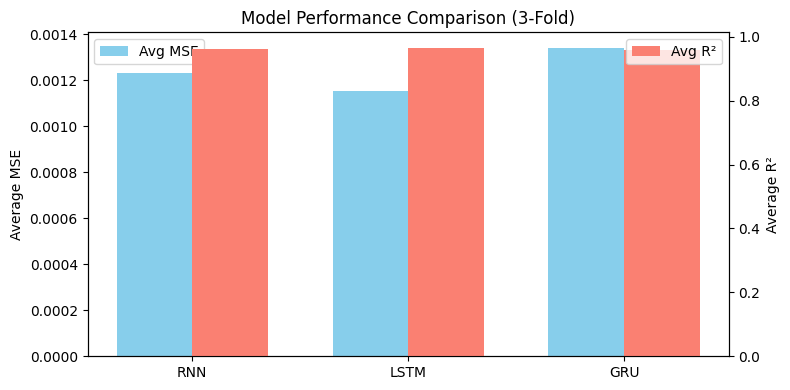

/var/folders/qy/7jvf7f8x5g1bdw0l864hm93w0000gn/T/ipykernel_41514/1256888345.py:42: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[0].boxplot(data_mse, labels=models)
/var/folders/qy/7jvf7f8x5g1bdw0l864hm93w0000gn/T/ipykernel_41514/1256888345.py:46: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[1].boxplot(data_r2, labels=models)


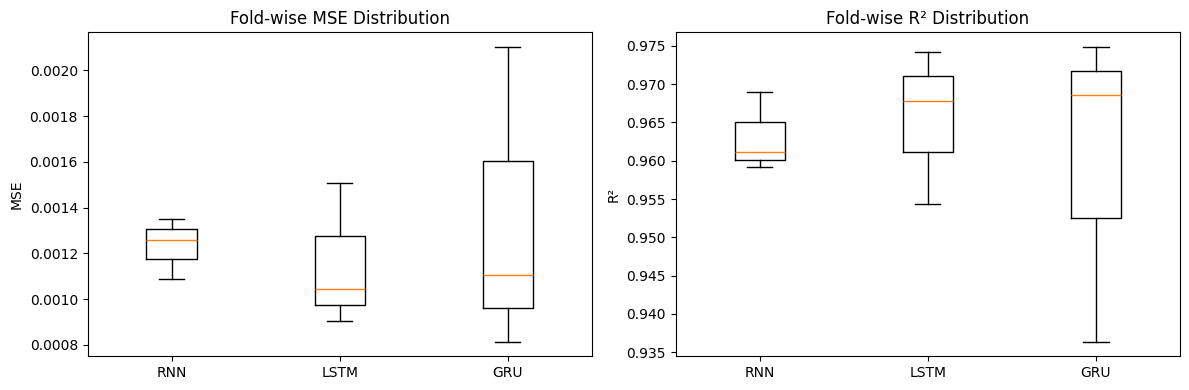

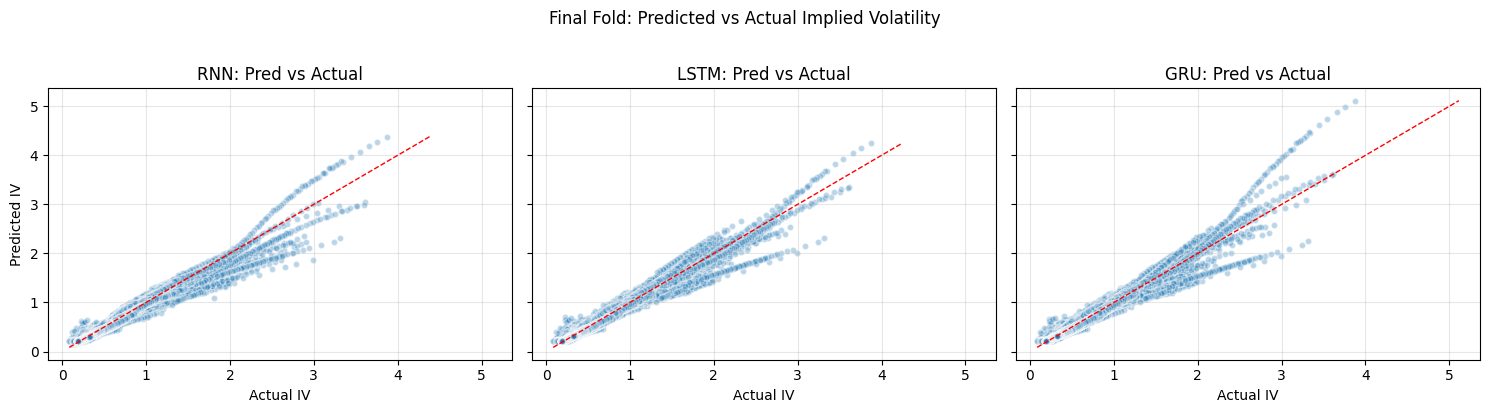

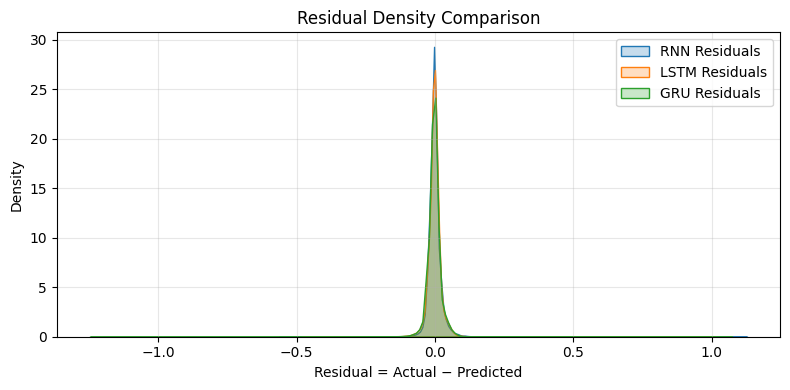

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Performance comparison bar plot
models = ['RNN', 'LSTM', 'GRU']
avg_mse = [np.mean(mse_rnn), np.mean(mse_lstm), np.mean(mse_gru)]
avg_r2 = [np.mean(r2_rnn), np.mean(r2_lstm), np.mean(r2_gru)]

x = np.arange(len(models))
width = 0.35

fig, ax1 = plt.subplots(figsize=(8, 4))
ax2 = ax1.twinx()

ax1.bar(x - width/2, avg_mse, width, label='Avg MSE', color='skyblue')
ax2.bar(x + width/2, avg_r2, width, label='Avg R²', color='salmon')

ax1.set_xticks(x)
ax1.set_xticklabels(models)
ax1.set_ylabel('Average MSE')
ax2.set_ylabel('Average R²')
ax1.set_title('Model Comparison Across Three Architectures')

ax1.legend(loc='upper left')
ax2.legend(loc='upper right')
plt.tight_layout()
plt.show()

# Distribution of fold-wise MSE and R²
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

data_mse = [mse_rnn, mse_lstm, mse_gru]
data_r2 = [r2_rnn, r2_lstm, r2_gru]

axes[0].boxplot(data_mse, labels=models)
axes[0].set_title('Fold-wise MSE')
axes[0].set_ylabel('MSE')

axes[1].boxplot(data_r2, labels=models)
axes[1].set_title('Fold-wise R²')
axes[1].set_ylabel('R²')

plt.tight_layout()
plt.show()

# Final fold: Predicted vs Actual scatter plots
fig, axs = plt.subplots(1, 3, figsize=(15, 4), sharex=True, sharey=True)

plot_data = [
    ('RNN', y_test_rnn, y_pred_rnn),
    ('LSTM', y_test_lstm, y_pred_lstm),
    ('GRU', y_test_gru, y_pred_gru)
]

for ax, (model_name, y_true, y_pred) in zip(axs, plot_data):
    ax.scatter(y_true, y_pred, alpha=0.3, edgecolor='w', s=20)
    lims = [min(y_true.min(), y_pred.min()), max(y_true.max(), y_pred.max())]
    ax.plot(lims, lims, 'r--', lw=1)
    ax.set_title(f'{model_name} Predictions')
    ax.set_xlabel('Actual IV')
    if ax is axs[0]:
        ax.set_ylabel('Predicted IV')
    ax.grid(alpha=0.3)

plt.suptitle('Predicted vs Actual (Final Fold)', y=1.02)
plt.tight_layout()
plt.show()

# Residual distributions for different models
residuals_rnn = y_test_rnn - y_pred_rnn
residuals_lstm = y_test_lstm - y_pred_lstm
residuals_gru = y_test_gru - y_pred_gru

plt.figure(figsize=(8, 4))
sns.kdeplot(residuals_rnn, label='RNN', fill=True)
sns.kdeplot(residuals_lstm, label='LSTM', fill=True)
sns.kdeplot(residuals_gru, label='GRU', fill=True)

plt.title('Residual Density Comparison Across Models')
plt.xlabel('Residual (Actual - Predicted)')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()